In [1]:
import numpy as np
import jax.numpy as jnp

from jax import grad
import jax
# from jax.example_libraries import optimizers

import matplotlib.pyplot as plt

# PyTorch

In [5]:
import torch
import torch.nn as nn

class FCN(nn.Module):
    "Defines a connected network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x
    
mu, k = 2*d, w0**2

torch.manual_seed(123)
model = FCN(1,1,5,2)

W1 = model.fcs[0].weight.data.numpy()
b1 = model.fcs[0].bias.data.numpy()

W2 = model.fch[0][0].weight.data.numpy()
b2 = model.fch[0][0].bias.data.numpy()

W3 = model.fce.weight.data.numpy()
b3 = model.fce.bias.data.numpy()

torch_params = [(W1.T, b1), (W2.T, b2), (W3.T, b3)]

In [4]:
torch_x_data = torch.tensor(np.array(x_data))
torch_y_data = torch.tensor(np.array(y_data))
torch_x_phy = torch.tensor(np.array(x_phy)).requires_grad_(True)

In [7]:
def train():

    optimizer = torch.optim.SGD(model.parameters(),lr=1e-4)

    for i in range(1000):
        optimizer.zero_grad()

        # compute the "data loss"
        yh = model(torch_x_data)
        loss1 = torch.mean((yh-torch_y_data)**2)# use mean squared error

        # compute the "physics loss"
        yhp = model(torch_x_phy)
        dx  = torch.autograd.grad(yhp, torch_x_phy, torch.ones_like(yhp), create_graph=True)[0]# computes dy/dx
        dx2 = torch.autograd.grad(dx,  torch_x_phy, torch.ones_like(dx),  create_graph=True)[0]# computes d^2y/dx^2
        physics = dx2 + mu*dx + k*yhp# computes the residual of the 1D harmonic oscillator differential equation
        loss2 = (1e-4)*torch.mean(physics**2)

        # backpropagate joint loss
        loss = loss1 + loss2# add two loss terms together
        loss.backward()
        optimizer.step()

#         if i%500 == 0:
# #             print("Loss after epoch {}: {}".format(i,loss))

In [8]:
%timeit train()

968 ms ± 18.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
for f in model.parameters():
#     print('data is')
#     print(f.data)
    print('grad is')
    print(f.grad)

# Dataset

(500, 1) (500, 1)
(10, 1) (10, 1)


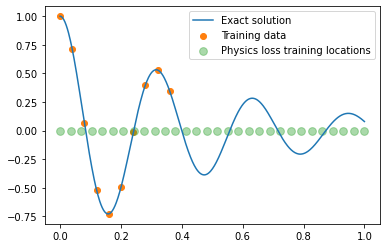

In [2]:
def oscillator(d, w0, x):
    """Defines the analytical solution to the 1D underdamped harmonic oscillator problem. 
    Equations taken from: https://beltoforion.de/en/harmonic_oscillator/"""
    assert d < w0
    w = jnp.sqrt(w0**2-d**2)
    phi = jnp.arctan(-d/w)
    A = 1/(2*jnp.cos(phi))
    cos = jnp.cos(phi+w*x)
    sin = jnp.sin(phi+w*x)
    exp = jnp.exp(-d*x)
    y  = exp*2*A*cos
    return y

d, w0 = 2, 20

# get the analytical solution over the full domain
x = jnp.expand_dims(jnp.linspace(0,1,500), axis = -1)
x_phy = jnp.expand_dims(jnp.linspace(0,1,30), axis = -1)
y = oscillator(d, w0, x)
print(x.shape, y.shape)

# slice out a small number of points from the LHS of the domain
x_data = x[0:200:20]
y_data = y[0:200:20]
print(x_data.shape, y_data.shape)

plt.figure()
plt.plot(x, y, label="Exact solution")
plt.scatter(x_data, y_data, color="tab:orange", label="Training data")
plt.scatter(x_phy, -0*jnp.ones_like(x_phy), s=60, color="tab:green", alpha=0.4, label='Physics loss training locations')
plt.legend()
plt.show()

# Initialising Parameters

Various initialisers can be found [here](https://jax.readthedocs.io/en/latest/jax.nn.initializers.html). Some examples are:
- `jax.nn.initializers.zeros()`
- `jax.nn.initializers.ones()`
- `jax.nn.initializers.uniform()`
- `jax.nn.initializers.normal()`
- `jax.nn.initializers.variance_scaling()`
- `jax.nn.initializers.glorot_uniform()`
- `jax.nn.initializers.glorot_normal()` 
- `jax.nn.initializers.lecun_uniform()`  
- `jax.nn.initializers.lecun_normal()`  
- `jax.nn.initializers.he_uniform()`
- `jax.nn.initializers.he_normal()`

In [3]:
def init_params(layers:list, seed:int) -> list:
    initialiser = jax.nn.initializers.glorot_normal()
    key = jax.random.PRNGKey(seed)
    
    params=[]
    for i in range(len(layers)-1):
        key, subkey = jax.random.split(key)
        W = initialiser(key=subkey, shape=(layers[i],layers[i+1]), dtype=jnp.float32)
        b = jnp.ones(shape=(layers[i+1],), dtype=jnp.float32)
        params.append(dict(Weights=W, Biases=b))
        
    return params

def init_params(torch_params:list) -> list:
    params=[]
    for i in range(len(torch_params)):
        W = torch_params[i][0]
        b = torch_params[i][1]
        params.append(dict(Weights=W, Biases=b))
        
    return params

In [6]:
layers = [1,32,32,32,1]
params = init_params(torch_params)

# Verifying shapes
jax.tree_map(lambda x:x.shape, params)

[{'Biases': (5,), 'Weights': (1, 5)},
 {'Biases': (5,), 'Weights': (5, 5)},
 {'Biases': (1,), 'Weights': (5, 1)}]

# Forward Pass

## Neural Net

In [7]:
@jax.jit
def forward(params:list, x:np.ndarray) -> np.ndarray:
    hidden = params[:-1]
    last = params[-1]
    for layer in hidden:
        z = jnp.dot(x,layer["Weights"]) + layer["Biases"]
        x = jax.nn.tanh(z)
        
    z = jnp.dot(x,last["Weights"]) + last["Biases"]
    return z

## Physics Equation

### 1st order derivative

In [8]:
@jax.jit
def first_deriv(params:list, x:np.ndarray) -> np.ndarray:
    def forward_(params:list, x:np.ndarray) -> np.ndarray:
        z = forward(params, x)
        return jnp.sum(z, axis=0)[0]
    
    u_x = jax.grad(forward_, argnums=(1))(params, x)
    return u_x

### 2nd order derivative

In [9]:
@jax.jit
def second_deriv(params:list, x:np.ndarray) -> np.ndarray:
    def first_deriv_(params:list, x:np.ndarray) -> np.ndarray:
        u_x = first_deriv(params, x)
        return jnp.sum(u_x, axis=0)[0]
    
    u_xx = jax.grad(first_deriv_, argnums=(1))(params, x)
    return u_xx

### Partial Differential Equation

In [10]:
@jax.jit
def equation(params:list, x_phy:np.ndarray, coeffs:dict) -> np.ndarray:
    '''
    m*u_xx + mu*u_x + k*u = 0
    '''
    m = coeffs["m"]
    mu = coeffs["mu"]
    k = coeffs["k"]
    
    u = forward(params, x_phy)
    u_x = first_deriv(params, x_phy)
    u_xx = second_deriv(params, x_phy)
    
    physics = m*u_xx + mu*u_x + k*u
    
    return physics

# Loss Function

In [11]:
@jax.jit
def loss(params:list, x_data:np.ndarray, 
         y_data:np.ndarray, x_phy:np.ndarray, 
         coeffs:dict) -> float:
    # Physics Loss
    eqn = equation(params, x_phy, coeffs)
    physics_loss = (1e-4)*jnp.mean(eqn**2)
    
    # Data Loss
    y_pred = forward(params, x_data)
    data_loss = jnp.mean((y_pred - y_data)**2)
    
    return physics_loss + data_loss

# Backward Pass

In [12]:
@jax.jit
def update(params:list, x_data:np.ndarray, y_data:np.ndarray, 
           x_phy:np.ndarray, coeffs:dict, lr:float):

    d_params = jax.grad(loss, argnums=(0))(params, x_data, y_data, x_phy, coeffs)
    return jax.tree_map(lambda p,g:p-lr*g, params, d_params)

# Train

In [18]:
def xlatrain(params, x_data, y_data, x_phy):
    m, mu, k = 1, 2*d, w0**2
    coeffs = dict(m=m, mu=mu, k=k)
    lr = 1e-4

    history = []
    for i in range(1000):
        params = update(params, x_data, y_data, x_phy, coeffs, lr)

#         if i%500==0:
#             l = loss(params, x_data, y_data, x_phy, coeffs)
#             print("Loss after epoch {}: {}".format(i,l))
#             history.append(l)

In [19]:
%timeit xlatrain(params, x_data, y_data, x_phy)

203 ms ± 2.01 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
